In [0]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1613      0 --:--:-- --:--:-- --:--:--  1613
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


## Setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

# Regression with BIWI head pose dataset

> This is a more advance example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db).

```
@article{fanelli_IJCV,
  author = {Fanelli, Gabriele and Dantone, Matthias and Gall, Juergen and Fossati, Andrea and Van Gool, Luc},
  title = {Random Forests for Real Time 3D Face Analysis},
  journal = {Int. J. Comput. Vision},
  year = {2013},
  month = {February},
  volume = {101}, 
  number = {3},
  pages = {437--458}
}
```


## Preparing dataset

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [0]:
path.ls()

In [0]:
cal = np.genfromtxt(path/"01"/"rgb.cal", skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f):
    return path/f"{str(f)[:-7]}pose.txt"

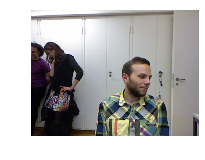

In [0]:
img = open_image(path/fname)
img.show()

In [0]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2, c1])

In [0]:
def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

In [0]:
def get_ip(img, pts):
    return ImagePoints(FlowField(img.size, pts), scale=True)

In [0]:
get_ctr(fname)

tensor([263.9104, 428.5814])

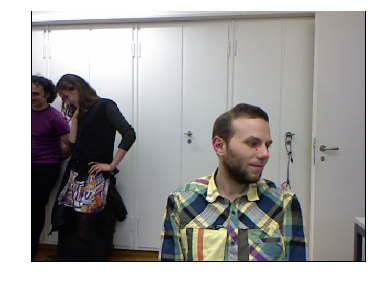

In [0]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Preparing dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda x: x.parent.name=="13")
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120, 160))
        .databunch().normalize(imagenet_stats))

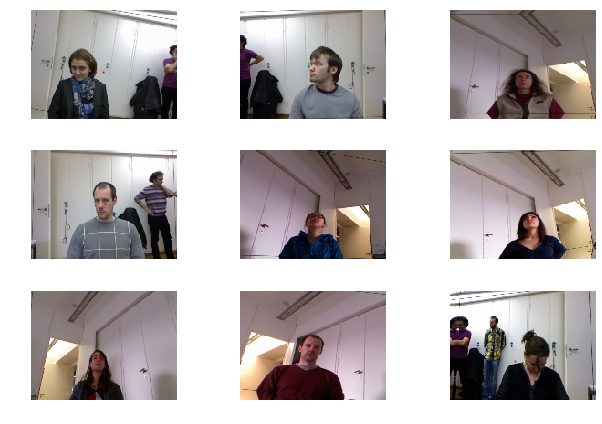

In [0]:
data.show_batch(3, figsize=(9, 6))

## Build model

In [0]:
learn = cnn_learner(data, models.resnet34)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


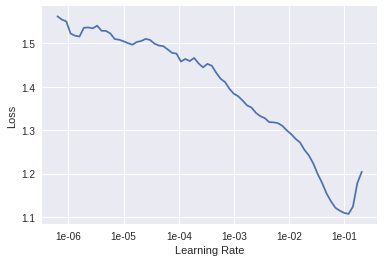

In [0]:
learn.recorder.plot()

In [0]:
lr = 2e-2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.035708,0.003323,03:51
1,0.012311,0.000722,03:54
2,0.005422,0.000407,03:56
3,0.003612,0.001247,03:56
4,0.002789,0.001299,03:56


In [0]:
learn.save("stage-1")

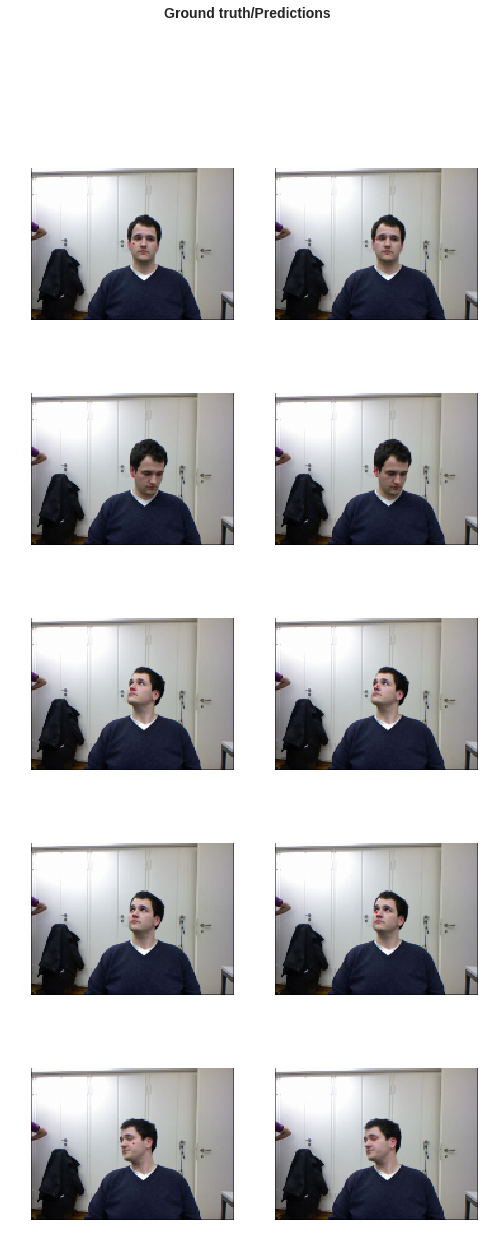

In [0]:
learn.show_results()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


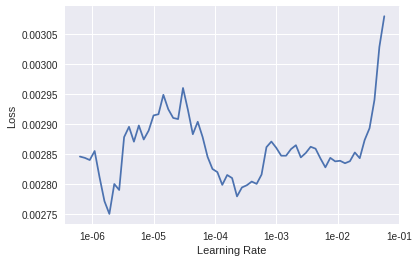

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,0.001859,0.000157,04:00
1,0.001040,0.000661,04:04
2,0.000788,0.000688,03:59
3,0.000710,0.000774,04:01
4,0.000748,0.000624,04:02


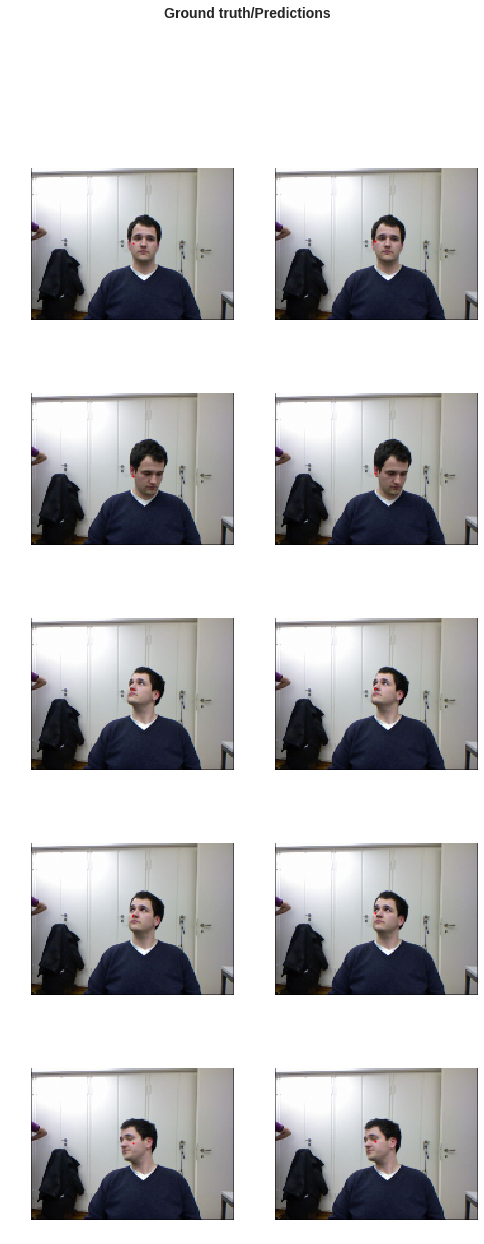

In [0]:
learn.show_results()

In [0]:
learn.save("stage-2")